<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/Keras_CNN_Dog_or_Cat_Classification_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import load_img
print(os.listdir("/content/drive/MyDrive/train"))

['train']


# Define Constants

In [24]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Training Data

In [5]:
filenames = os.listdir("/content/drive/MyDrive/train_700.zip (Unzipped Files)")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,cat.517.jpg,0
1,cat.515.jpg,0
2,cat.514.jpg,0
3,cat.513.jpg,0
4,cat.512.jpg,0


In [7]:
df.tail()

,filename,category
772,dog.145.jpg,1
773,dog.144.jpg,1
774,dog.141.jpg,1
775,dog.143.jpg,1
776,dog.142.jpg,1


**See Total in count**

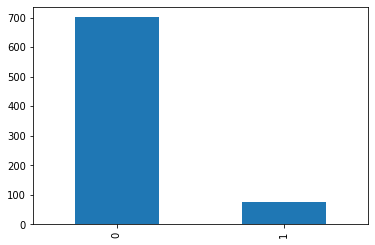

In [8]:
df['category'].value_counts().plot.bar()

**See sample image**

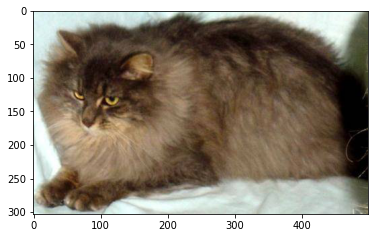

In [12]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/train_700.zip (Unzipped Files)/"+sample)
plt.imshow(image)

# **Build Model**

* Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* Conv Layer: This layer will extract features from image.
* Pooling Layer: This layerreduce the spatial volume of input image after convolution.
* Fully Connected Layer: It connect the network from a layer to another layer
* Output Layer: It is the predicted values layer.

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)      

# Callbacks

In [26]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early stop** : 오버피팅 예방 위해 10 epoch 학습하면 stop

In [27]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [29]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

In [30]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [31]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

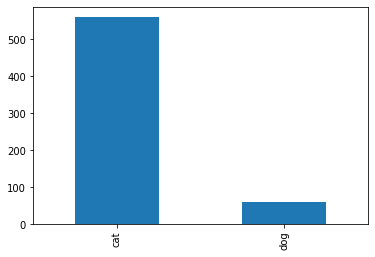

In [32]:
train_df['category'].value_counts().plot.bar()

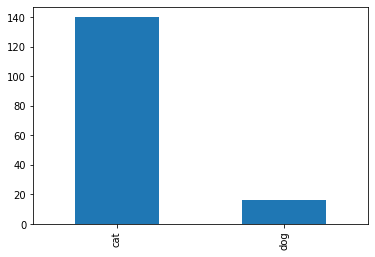

In [33]:
validate_df['category'].value_counts().plot.bar()

In [34]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training Generator

In [43]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/train_700.zip (Unzipped Files)", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 621 validated image filenames belonging to 2 classes.


**Validation Generator**

In [44]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/train_700.zip (Unzipped Files)", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 156 validated image filenames belonging to 2 classes.


In [46]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/train_700.zip (Unzipped Files)", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


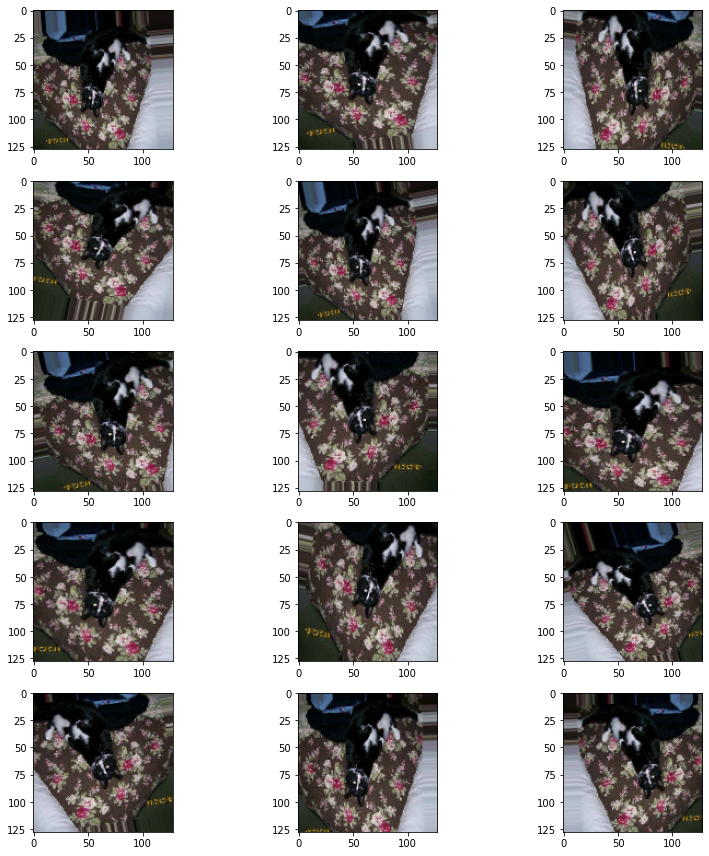

In [47]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit

In [48]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-48-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 1.1182 - accuracy: 0.6007

41/41 [==============================] - 42s 946ms/step - loss: 1.1182 - accuracy: 0.6007 - val_loss: 4.2022 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.7376

41/41 [==============================] - 40s 970ms/step - loss: 0.6761 - accuracy: 0.7376 - val_loss: 7.1715 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.8119

41/41 [==============================] - 36s 883ms/step - loss: 0.5046 - accuracy: 0.8119 - val_loss: 7.5846 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.8449

41/41 [==============================] - 37s 893ms/step - loss: 0.4921 - accuracy: 0.8449 - val_loss: 6.1911 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.8185

41/41 [==============================] - 37s 896ms/step - loss: 0.6098 - accuracy: 0.8185 - val_loss: 4.1056 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.8300

41/41 [==============================] - 38s 930ms/step - loss: 0.5731 - accuracy: 0.8300 - val_loss: 2.1477 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.8498

41/41 [==============================] - 36s 883ms/step - loss: 0.4874 - accuracy: 0.8498 - val_loss: 1.5946 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 8/50
41/41 [==============================] - ETA: 0s - loss: 0.4695 - accuracy: 0.8762

41/41 [==============================] - 37s 896ms/step - loss: 0.4695 - accuracy: 0.8762 - val_loss: 0.8717 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 9/50
41/41 [==============================] - ETA: 0s - loss: 0.4022 - accuracy: 0.8762

41/41 [==============================] - 37s 893ms/step - loss: 0.4022 - accuracy: 0.8762 - val_loss: 1.2319 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 10/50
41/41 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.8779

41/41 [==============================] - 37s 890ms/step - loss: 0.4241 - accuracy: 0.8779 - val_loss: 0.7682 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 11/50
41/41 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.8779

41/41 [==============================] - 37s 904ms/step - loss: 0.4414 - accuracy: 0.8779 - val_loss: 0.9191 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 12/50
41/41 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.8762

41/41 [==============================] - 39s 954ms/step - loss: 0.4060 - accuracy: 0.8762 - val_loss: 0.6945 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 13/50
41/41 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.8845

41/41 [==============================] - 37s 912ms/step - loss: 0.3663 - accuracy: 0.8845 - val_loss: 0.4958 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 14/50
41/41 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.8845

41/41 [==============================] - 38s 913ms/step - loss: 0.3609 - accuracy: 0.8845 - val_loss: 0.5781 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 15/50
41/41 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8927

41/41 [==============================] - 37s 894ms/step - loss: 0.3793 - accuracy: 0.8927 - val_loss: 0.8796 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 16/50
41/41 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.8779

41/41 [==============================] - 39s 963ms/step - loss: 0.3521 - accuracy: 0.8779 - val_loss: 0.6433 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 17/50
41/41 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.8927

41/41 [==============================] - 38s 916ms/step - loss: 0.3520 - accuracy: 0.8927 - val_loss: 0.5276 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 18/50
41/41 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.8680

41/41 [==============================] - 38s 930ms/step - loss: 0.3859 - accuracy: 0.8680 - val_loss: 0.4984 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 19/50
41/41 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.9109

41/41 [==============================] - 37s 903ms/step - loss: 0.2840 - accuracy: 0.9109 - val_loss: 0.4768 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 20/50
41/41 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8911

41/41 [==============================] - 37s 893ms/step - loss: 0.3257 - accuracy: 0.8911 - val_loss: 0.5166 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 21/50
41/41 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.9026

41/41 [==============================] - 36s 886ms/step - loss: 0.3066 - accuracy: 0.9026 - val_loss: 0.4199 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 22/50
41/41 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.9076

41/41 [==============================] - 36s 878ms/step - loss: 0.3234 - accuracy: 0.9076 - val_loss: 0.3673 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 23/50
41/41 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8894

41/41 [==============================] - 37s 898ms/step - loss: 0.3021 - accuracy: 0.8894 - val_loss: 0.3551 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 24/50
41/41 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.8845

41/41 [==============================] - 38s 934ms/step - loss: 0.3173 - accuracy: 0.8845 - val_loss: 0.4884 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 25/50
41/41 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.9057

41/41 [==============================] - 37s 895ms/step - loss: 0.2910 - accuracy: 0.9057 - val_loss: 0.8361 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 26/50
41/41 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.9158

41/41 [==============================] - 37s 897ms/step - loss: 0.2674 - accuracy: 0.9158 - val_loss: 0.7041 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 27/50
41/41 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.9059

41/41 [==============================] - 37s 906ms/step - loss: 0.2982 - accuracy: 0.9059 - val_loss: 0.3793 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 28/50
41/41 [==============================] - ETA: 0s - loss: 0.2463 - accuracy: 0.9109

41/41 [==============================] - 37s 890ms/step - loss: 0.2463 - accuracy: 0.9109 - val_loss: 0.6974 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 29/50
41/41 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.9026

41/41 [==============================] - 37s 893ms/step - loss: 0.2920 - accuracy: 0.9026 - val_loss: 0.7618 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 30/50
41/41 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9092

41/41 [==============================] - 38s 928ms/step - loss: 0.2486 - accuracy: 0.9092 - val_loss: 0.3800 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 31/50
41/41 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9208

41/41 [==============================] - 37s 890ms/step - loss: 0.2753 - accuracy: 0.9208 - val_loss: 0.3829 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 32/50
41/41 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.9043

41/41 [==============================] - 37s 892ms/step - loss: 0.2749 - accuracy: 0.9043 - val_loss: 0.8096 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 33/50
41/41 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.9274

41/41 [==============================] - 36s 886ms/step - loss: 0.2418 - accuracy: 0.9274 - val_loss: 0.3856 - val_accuracy: 0.8733 - lr: 0.0010


In [49]:
# Save Model
model.save_weights("model.h5")

# Virtualize Training

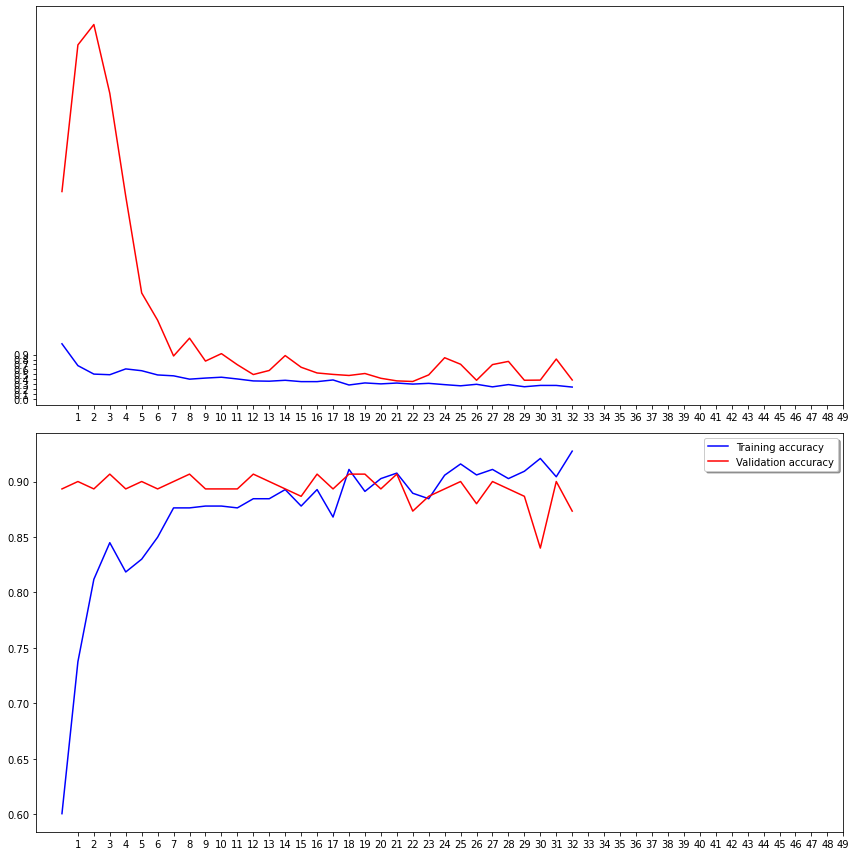

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [54]:
test_filenames = os.listdir("/content/drive/MyDrive/test_500.zip (Unzipped Files)")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [56]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/test_500.zip (Unzipped Files)", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


# Predict

In [57]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-57-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [58]:
test_df['category'] = np.argmax(predict, axis=-1)

In [59]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [60]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

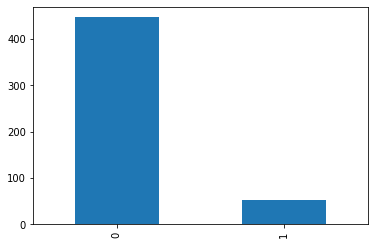

In [61]:
# Virtualize result
test_df['category'].value_counts().plot.bar()

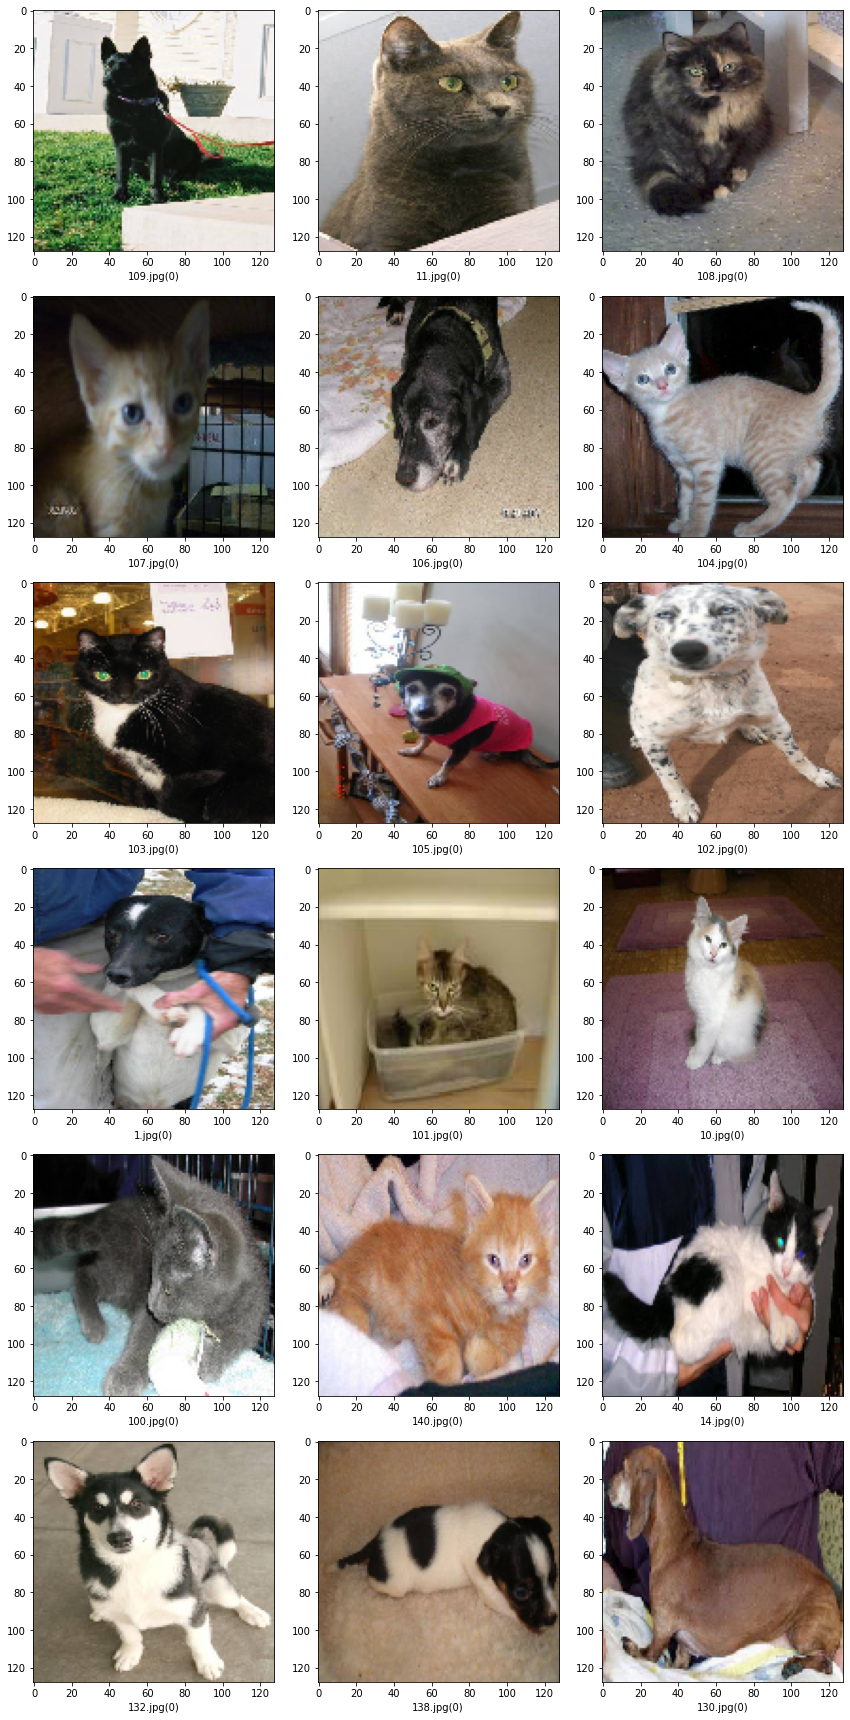

In [64]:
# See predicted result with images
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/test_500.zip (Unzipped Files)/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()